In [2]:
import pandas as pd
import ast

In [5]:
df = pd.read_parquet("../data/webquestions/webquestions-frob.parquet")
df["answers"] = df["answers"].apply(lambda s: ast.literal_eval(s) if isinstance(s, str) else s)
print(df.columns)
print(df.groupby("labels")["frob"].describe())
print(df.groupby("labels")["f1_rms"].describe())


Index(['question', 'answers', 'labels', 'predictions', 'f1_rms', 'frob'], dtype='object')
          count      mean       std       min       25%       50%       75%  \
labels                                                                        
far-ood   853.0  0.559773  0.063360  0.220334  0.532577  0.574985  0.602751   
in        271.0  0.510580  0.089277  0.144384  0.455998  0.529610  0.578275   
near-ood  299.0  0.516282  0.088281  0.185624  0.463072  0.539473  0.583913   

               max  
labels              
far-ood   0.669850  
in        0.662562  
near-ood  0.660323  
          count      mean       std       min       25%       50%       75%  \
labels                                                                        
far-ood   853.0  0.922890  0.094973  0.312667  0.895855  0.960994  0.983853   
in        271.0  0.877010  0.131618  0.354604  0.826090  0.930061  0.970943   
near-ood  299.0  0.886731  0.125009  0.227025  0.837668  0.937929  0.974770   

             

<Figure size 600x400 with 0 Axes>

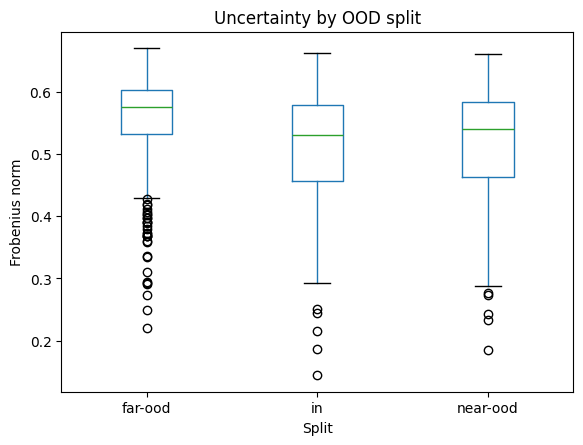

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
df.boxplot(column="frob", by="labels", grid=False)
plt.title("Uncertainty by OOD split")
plt.suptitle("")
plt.xlabel("Split")
plt.ylabel("Frobenius norm")
plt.show()


<Figure size 600x400 with 0 Axes>

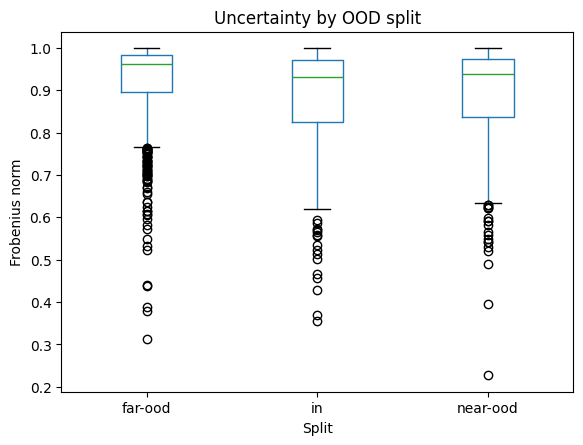

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
df.boxplot(column="f1_rms", by="labels", grid=False)
plt.title("Uncertainty by OOD split")
plt.suptitle("")
plt.xlabel("Split")
plt.ylabel("Frobenius norm")
plt.show()


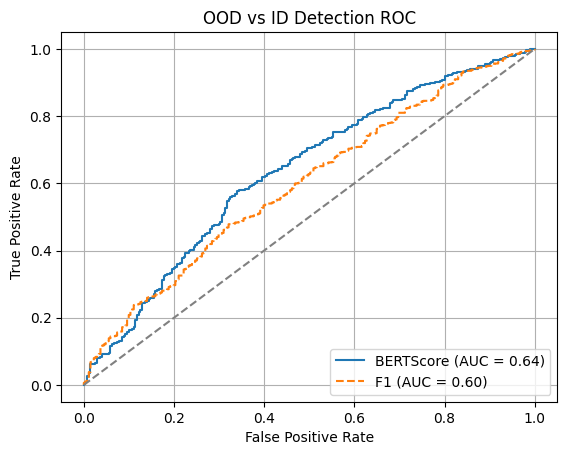

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ground‐truth
y_true  = (df["labels"] != "in").astype(int)

# first classifier: Frobenius‐based score
y_score1 = df["frob"].to_numpy()
fpr1, tpr1, _ = roc_curve(y_true, y_score1)
roc_auc1     = auc(fpr1, tpr1)

# second classifier: F1‐RMS‐based score
y_score2 = df["f1_rms"].to_numpy()
fpr2, tpr2, _ = roc_curve(y_true, y_score2)
roc_auc2     = auc(fpr2, tpr2)

# plot both on one figure
plt.plot(fpr1, tpr1, label=f"BERTScore (AUC = {roc_auc1:.2f})")
plt.plot(fpr2, tpr2, label=f"F1 (AUC = {roc_auc2:.2f})", linestyle="--")

# chance line
plt.plot([0,1], [0,1], "--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("OOD vs ID Detection ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


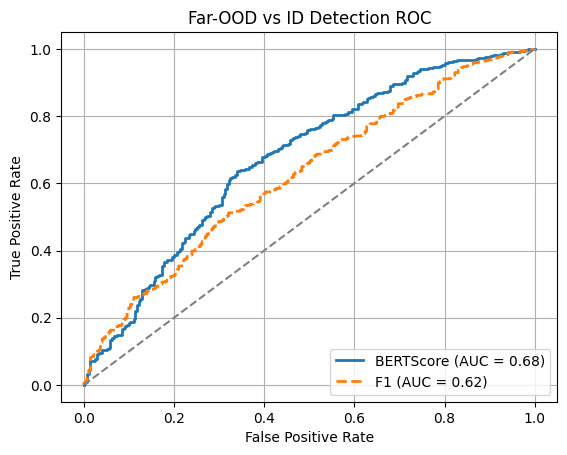

In [14]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 1) select only in‐distribution vs far‐OOD rows
mask = df["labels"].isin(["in", "far-ood"])
y_true = (df.loc[mask, "labels"] == "far-ood").astype(int)

# 2) first classifier: Frobenius‐based score
y_score1 = df.loc[mask, "frob"].to_numpy()
fpr1, tpr1, _ = roc_curve(y_true, y_score1)
roc_auc1     = auc(fpr1, tpr1)

# 3) second classifier: F1-RMS‐based score
y_score2 = df.loc[mask, "f1_rms"].to_numpy()
fpr2, tpr2, _ = roc_curve(y_true, y_score2)
roc_auc2     = auc(fpr2, tpr2)

# 4) plot both on one figure
# plt.figure(figsize=(6,6))
plt.plot(fpr1, tpr1, label=f"BERTScore (AUC = {roc_auc1:.2f})", linewidth=2)
plt.plot(fpr2, tpr2, label=f"F1 (AUC = {roc_auc2:.2f})", linestyle="--", linewidth=2)

# chance line
plt.plot([0,1], [0,1], "--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Far-OOD vs ID Detection ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


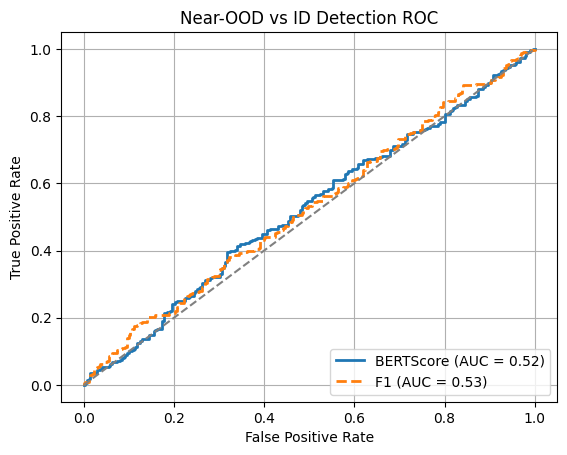

In [15]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 1) select only in‐distribution vs far‐OOD rows
mask = df["labels"].isin(["in", "near-ood"])
y_true = (df.loc[mask, "labels"] == "near-ood").astype(int)

# 2) first classifier: Frobenius‐based score
y_score1 = df.loc[mask, "frob"].to_numpy()
fpr1, tpr1, _ = roc_curve(y_true, y_score1)
roc_auc1     = auc(fpr1, tpr1)

# 3) second classifier: F1-RMS‐based score
y_score2 = df.loc[mask, "f1_rms"].to_numpy()
fpr2, tpr2, _ = roc_curve(y_true, y_score2)
roc_auc2     = auc(fpr2, tpr2)

# 4) plot both on one figure
# plt.figure(figsize=(6,6))
plt.plot(fpr1, tpr1, label=f"BERTScore (AUC = {roc_auc1:.2f})", linewidth=2)
plt.plot(fpr2, tpr2, label=f"F1 (AUC = {roc_auc2:.2f})", linestyle="--", linewidth=2)

# chance line
plt.plot([0,1], [0,1], "--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Near-OOD vs ID Detection ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [19]:
from collections import Counter


def most_frequent(lst: list[str]) -> str:
    filtered = [s for s in lst if s]
    return Counter(filtered).most_common(1)[0][0]


df["hard_pred"] = df["predictions"].apply(most_frequent)

print(df[df["labels"] == "in"].head())

                                             question  \
6                  what else did ben franklin invent?   
11  where is the fukushima daiichi nuclear plant l...   
12  who is the minority leader of the house of rep...   
22              what is the australian dollar called?   
23                           what timezone is sweden?   

                                              answers labels  \
6   [Lightning rod, Franklin stove, Bifocals, Glas...     in   
11                                     [Japan, Okuma]     in   
12                                     [Nancy Pelosi]     in   
22                                [Australian dollar]     in   
23                            [Central European Time]     in   

                                          predictions    f1_rms      frob  \
6   [GoldInPhGold, Hein-de-Von, Bifocillism, Bifib...  0.980588  0.588394   
11  [Okanaya, Japan, Tokyo, Okazaki, Japan, Okazak...  0.840694  0.432301   
12  [Clutor Méséx, Nancy Pelosi, Solovie 

In [20]:
def is_exact_match(pred: str, golds: list[str]) -> bool:
    return pred in golds

df["correct"] = df.apply(
    lambda r: is_exact_match(r["hard_pred"], r["answers"]),
    axis=1,
)

# per split EM score
print(100 * df.groupby("labels")["correct"].sum() / df.groupby("labels")["correct"].count())
print(df.groupby("labels")["correct"].sum())
print(df.groupby("labels")["correct"].count())

# overall EM score
print(100 * df["correct"].sum() / df["correct"].count())
print(df["correct"].sum())
print(df["correct"].count())

labels
far-ood      0.586166
in          33.579336
near-ood    17.725753
Name: correct, dtype: float64
labels
far-ood      5
in          91
near-ood    53
Name: correct, dtype: int64
labels
far-ood     853
in          271
near-ood    299
Name: correct, dtype: int64
10.470836261419537
149
1423


In [51]:
df[(df["correct"]) & (df["labels"] == "far-ood")]

,question,answers,labels,predictions,frob,hard_pred,correct
265,how deep is lake merritt oakland?,[Oakland],far-ood,"[Lake Merritt, Oakland, Oakland, How deep is l...",0.483534,Oakland,True
477,when does school start for the university of o...,[University of Oregon],far-ood,"[Oregon state, Oregon Institute of Technology,...",0.507418,University of Oregon,True
673,what county is san diego ca?,[San Diego County],far-ood,"[Guatemala, Central San Diego County, San Dieg...",0.367694,San Diego County,True
787,what county is san diego in?,[San Diego County],far-ood,"[Los Angeles County, California, San Diego Cou...",0.358204,San Diego County,True
1287,what currency does singapore use?,[Singapore dollar],far-ood,"[Singpore franc, Miamic, Singapore Singaporeen...",0.373442,Singapore dollar,True


In [67]:
random_row = df[(df["correct"]) & (df["labels"] == "in") & (df["frob"] < 0.5)].sample(n=1).iloc[0]

random_row = df[df["question"] == "what countries does canada have trade agreements with?"].iloc[0]

import random

print(random_row["question"])
print(random_row["answers"])
print(Counter(random_row["predictions"]))
# print(random.sample(sorted(random_row["predictions"]), 10))
print(random_row["frob"])
print(random_row["f1_rms"])


what countries does canada have trade agreements with?
['United Kingdom', 'Japan', 'United States of America']
Counter({'United States of America': 12, 'Canada': 6, 'United States of Canada': 2, 'CanadaCanada': 2, 'New Zealand': 2, 'Guatemala': 1, 'U.S.': 1, 'Sudan': 1, 'Chile': 1, 'United States of America Charter': 1, 'United StatesUnited States of America': 1})
0.4478064145669007
0.820149608920956
